In [14]:
%matplotlib inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

In [15]:
!ls data

glg_ctime_b0_bn200224416_v00.pha    glg_healpix_all_bn200224416_v01.fit
glg_ctime_b0_bn200224416_v02.rsp    glg_trigdat_all_bn200224416_v01.fit
glg_ctime_b0_bn200224416_v02.rsp2


In [16]:
#from https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/bursts/2020/bn200224416/current/
fname="data/glg_healpix_all_bn200224416_v01.fit"
fname="data/glg_trigdat_all_bn200224416_v01.fit"
fname="data/glg_ctime_b0_bn200224416_v00.pha"
fits.info(fname)

Filename: data/glg_ctime_b0_bn200224416_v00.pha
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      37   ()      
  1  EBOUNDS       1 BinTableHDU     58   8R x 3C   [1I, 1E, 1E]   
  2  SPECTRUM      1 BinTableHDU     72   14824R x 5C   [8I, 1E, 1I, 1D, 1D]   
  3  GTI           1 BinTableHDU     44   1R x 2C   [1D, 1D]   


### from time-resolved (8-bin) spectra

In [23]:
fname="https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/bursts/2020/bn%s/current/glg_ctime_n%i_bn%s_v00.pha" #NaI det spectra
fname2="https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/bursts/2020/bn%s/current/glg_ctime_b%i_bn%s_v00.pha" #BGO det
bid="200412381"
bid="200224416"
ndet=5 #from 0 to 11
dd=fits.getdata(fname%(bid,ndet,bid),ext=2)
times=np.array([d[3] for d in dd])
allcurves=np.array([d[0] for d in dd])
expo=times[1:]-times[:-1] #time of integration

In [24]:
#bid='200224416'
dd2=fits.getdata(fname%(bid,0,bid),ext=2)
times2=np.array([d[3] for d in dd2]) #same as times
allcurves2=np.array([d[0] for d in dd2])
dd2[5]

(array([26, 78, 46, 40, 50,  6,  9, 22], dtype=uint16), 0.25512588, 0, 604230130.81251, 604230131.068528)

/Users/toast/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/toast/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/toast/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


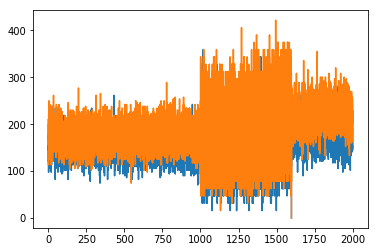

In [26]:
t0=times[0]
tmax=times[np.argmax(allcurves[:-1,4]/expo)]-t0
plt.plot(times[:-1]-t0,allcurves[:-1,3]/expo) #energy channel 4
plt.plot(times[:-1]-t0,allcurves[:-1,4]/expo) #energy channel 5
#plt.xlim(tmax-20,tmax+20)

/Users/toast/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/toast/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


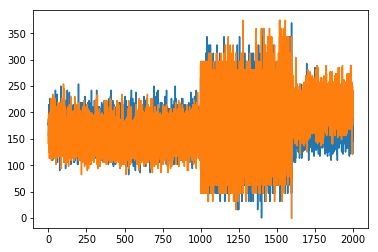

In [27]:
#t0=times[0]
#tmax=times[np.argmax(allcurves[:-1,4]/expo)]-t0
plt.plot(times[:-1]-t0,allcurves2[:-1,3]/expo)
plt.plot(times[:-1]-t0,allcurves2[:-1,4]/expo)
#plt.xlim(tmax-20,tmax+20)

/Users/toast/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


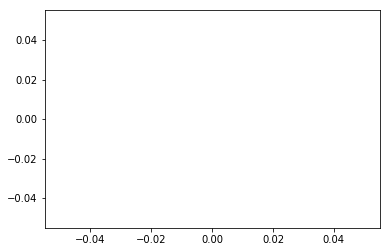

In [22]:
sel1=abs(times[:-1]-t0-tmax)<40
exsel=expo[sel1]
emin=3
c1,c2=allcurves[:-1,emin][sel1]/exsel,allcurves2[:-1,emin][sel1]/exsel
c1-=c1[-100:].mean()
c2-=c2[-100:].mean()
mcurv=np.correlate(c1,c2,"same")
plt.plot(mcurv)

### from event list - user defined binning

In [39]:
fname3="https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/bursts/2020/bn%s/current/glg_tte_n%i_bn%s_v00.fit"
elist=fits.getdata(fname3%(bid,5,bid),ext=2)
elist2=fits.getdata(fname3%(bid,3,bid),ext=2)
#elist
np.savez("tdata.npz",[elist,elist2])

In [40]:
pack=np.load("tdata.npz",allow_pickle=True)
elist,elist2=pack['arr_0']

In [41]:
def lcurve(time,fac=600,sub=0):
    #fac: grouping factor - binning = 1/fac seconds
    tlab=(time*fac).astype(int)
    pos=np.r_[0,np.where(tlab[1:]-tlab[:-1])[0]]
    cnt=pos[1:]-pos[:-1]
    if sub!=0: #baseline
        basel=np.median(cnt[sub:])
        cnt=cnt.astype(float)-basel
    return np.r_[tlab[0]:tlab[0]+len(cnt)]/fac,cnt*fac

t0=elist['TIME'][0]
tevs=elist['TIME']-t0
t,r=lcurve(tevs,50)
#pl.plot(t,r)
tmax=t[np.argmax(r)]
sel2=abs(tevs-tmax)<40
evts=elist['PHA'][sel2]

tevs2=elist2['TIME']-t0
sel22=abs(tevs2-tmax)<40
evts2=elist2['PHA'][sel22]

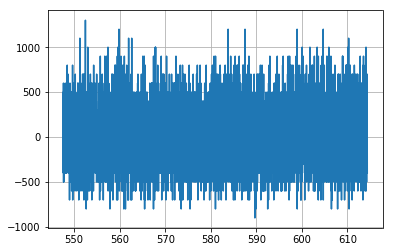

In [42]:
bin1,cur1=lcurve(tevs[sel2],100,-200)
plt.plot(bin1,cur1)
plt.grid()

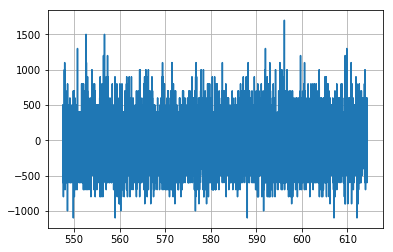

In [43]:
bin2,cur2=lcurve(tevs2[sel22],100,-200)
plt.plot(bin2,cur2)
plt.grid()


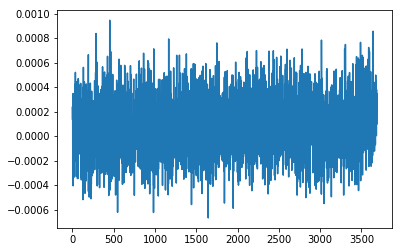

In [45]:
#len(cnt)
qmid,qsiz=40,15
nor1,nor2=1/cur1.sum(),1/cur2.sum()
fac=100 #10 ms
cfunc=np.correlate(cur1[(qmid-qsiz)*fac:(qmid+qsiz)*fac]*nor1,cur2*nor2,"valid")
plt.plot(cfunc)
cmax=np.argmax(cfunc)
#pl.xlim(cmax-500,cmax+500)

/Users/toast/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
/Users/toast/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/toast/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


[450.88056261203815,
 -11.388929219115294,
 1.8921621674756457,
 34.7070448591319,
 7.65488254502368e-05,
 2.317882755296653e-05]

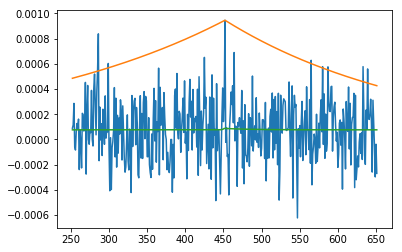

In [48]:
#fitting the maxima for sub-bin precission
def fit_corr(cfunc,csiz=200,doplot=True):
    cmax=np.argmax(cfunc)
    p0=[cmax,np.log(cfunc.max()),300,250,0]
    from scipy import optimize as op
    x=np.r_[cmax-csiz:cmax+csiz]
    fun1=lambda p:np.exp(-(p[0]-x)/p[2]+p[1])*(x<p[0])+(x>=p[0])*np.exp(-(x-p[0])/p[3]+p[1])+p[4]
    bst=op.fmin(lambda p:((cfunc[cmax-csiz:cmax+csiz]-fun1(p))**2).sum(),p0,disp=0)
    #pl.xlim(cmax-500,cmax+500)
    if doplot:
        plt.plot(x,cfunc[cmax-csiz:cmax+csiz],x,fun1(p0),x,fun1(bst))
    #pl.plot(x,fun1(p0))
    chi2=((cfunc[cmax-csiz:cmax+csiz]-fun1(bst))**2).sum()
    return list(bst)+[chi2]

fit_corr(cfunc)

In [49]:
fac=100
# testing small time shifts in both curves = change of binning
res=[]
for i in range(10):
    dt=i*0.1/fac
    bin1,cur1=lcurve(tevs[sel2]+dt,fac,-2*fac)
    bin2,cur2=lcurve(tevs2[sel22]+dt,fac,-2*fac)
    nor1,nor2=1/cur1.sum(),1/cur2.sum()
    res.append(fit_corr(np.correlate(cur1[(qmid-qsiz)*fac:(qmid+qsiz)*fac]*nor1,cur2*nor2,"valid"),doplot=False))
res=np.array(res)
res[:,0]

/Users/toast/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
/Users/toast/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/toast/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


ValueError: operands could not be broadcast together with shapes (298,) (400,) 

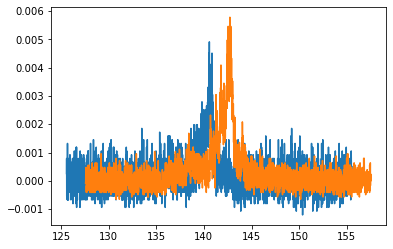

In [132]:
dt,dt2=0,2.
bin1,cur1=lcurve(tevs[sel2]+dt,fac,-2*fac)
bin2,cur2=lcurve(tevs2[sel22]+dt+dt2,fac,-2*fac)
nor1,nor2=1/cur1.sum(),1/cur2.sum()
pl.plot(bin1[(qmid-qsiz)*fac:(qmid+qsiz)*fac],cur1[(qmid-qsiz)*fac:(qmid+qsiz)*fac]*nor1)
pl.plot(bin2[(qmid-qsiz)*fac:(qmid+qsiz)*fac],cur2[(qmid-qsiz)*fac:(qmid+qsiz)*fac]*nor2)

In [133]:
#shifting 2nd curve wrt 1st one
fac=100
gres=[]
lcshift=np.r_[0:200./fac:10j]
for dt2 in lcshift:    
    res=[]
    for i in range(10):
        dt=i*0.1/fac
        bin1,cur1=lcurve(tevs[sel2]+dt,fac,-2*fac)
        bin2,cur2=lcurve(tevs2[sel22]+dt+dt2,fac,-2*fac)
        nor1,nor2=1/cur1.sum(),1/cur2.sum()
        res.append(fit_corr(np.correlate(cur2[(qmid-qsiz)*fac:(qmid+qsiz)*fac]*nor2,cur1*nor1,"valid"),doplot=False))
    gres.append(res)
gres=np.array(gres)
gres[:,:,0].mean(1)

array([2499.76181528, 2500.18839719, 2500.02423928, 2499.44702508,
       2499.45858562, 2499.67846459, 2500.11168383, 2499.93440118,
       2499.55382381, 2499.76181528])

<ErrorbarContainer object of 3 artists>

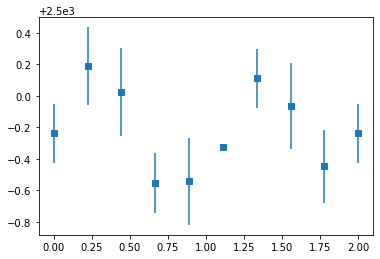

In [134]:
pl.errorbar(lcshift,gres[:,:,0].mean(1),gres[:,:,0].std(1)/np.sqrt(10),fmt='s')

In [122]:
gres[:,:,0].std(0),gres[:,:,0].std(1)

(array([1.00545489, 0.85076897, 0.28109647, 0.69282169, 0.87527583,
        0.87665498, 0.92077662, 1.01057198, 0.68109019, 0.7133978 ]),
 array([0.59381367, 0.90006216, 0.89952512, 0.60114414, 0.87905743,
        0.02751533, 0.90702352, 0.86531695, 0.72736948, 0.59381367]))

### something (completely) different

In [22]:
# directory listing on the server
if False:
    import ftplib
    ftp = ftplib.FTP("heasarc.gsfc.nasa.gov")
    ftp.login("anonymous", "ftplib-example-1")

import requests
from bs4 import BeautifulSoup

def get_url_paths(url, ext='', params={}):
    response = requests.get(url, params=params)
    if response.ok:
        response_text = response.text
    else:
        return response.raise_for_status()
    soup = BeautifulSoup(response_text, 'html.parser')
    parent = [url + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]
    return parent

url = 'https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/bursts/2020/bn200224416/quicklook/'
ext = 'pdf'
result = get_url_paths(url, ext)
print(result)

['https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/bursts/2020/bn200224416/quicklook/glg_lc_chan12_bn200224416.pdf', 'https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/bursts/2020/bn200224416/quicklook/glg_lc_chan34_bn200224416.pdf', 'https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/bursts/2020/bn200224416/quicklook/glg_lc_chan567_bn200224416.pdf', 'https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/bursts/2020/bn200224416/quicklook/glg_lc_chantot_bn200224416.pdf', 'https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/bursts/2020/bn200224416/quicklook/glg_lc_tot_bn200224416.pdf']


In [ ]:
# tipovat GRB200412381, GRB200125864, GRB200313071 - nejjasnejsi